<a href="https://colab.research.google.com/github/Renzou1/treinamento-h2ia/blob/main/09_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP no MNIST database
Rede neural com um hidden layer com 80% de acurácia no digits dataset. Foi usado uma loss não convencional por motivos de aprendizado/ teste de intuição.

In [ ]:
from sklearn import datasets
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
def relu(x):
  return max(0, x)

def relu_derivative(x):
    return (x > 0)

In [ ]:
class Perceptron:
  def __init__(self, n_weights):
    # gradients on the right
    self.inputs = np.empty(n_weights)
    self.n_weights = n_weights
    self.weights = np.random.random(n_weights)
    self.weights_g = np.zeros(n_weights)
    self.bias = np.random.random(1)[0]
    self.bias_g = 0
    self.inputs = 0  # can be later replaced by MLP`s inputs as a whole
    self.output = 0

  def __call__(self, inputs):
    self.inputs = np.array(inputs)
    self.output = (self.weights * inputs).sum()
    self.output += self.bias
    return relu(self.output)

  def backpropagation(self, chain_g):
    if chain_g == 0:
      return self.weights_g

    relu_derivative_output = relu_derivative(self.output)
    chain_g = chain_g * relu_derivative_output

    self.weights_g += self.inputs * chain_g
    self.bias_g += chain_g
    #reminder: the direction of the gradient is opposite because of
    # the negation of the learning rate later
    self.weights_g = np.clip(self.weights_g, -1, 1)

    return self.weights_g

  def update(self, learning_rate):
    self.weights += -learning_rate * self.weights_g
    self.bias += -learning_rate * self.bias_g

  def zero_grad(self):
    self.bias_g = 0
    self.weights_g = np.zeros(self.n_weights)

In [ ]:
class Layer:
  def __init__(self, n_weights, size):
    self.neurons = [Perceptron(n_weights) for _ in range(size)]
    self.inputs = 0

  def __call__(self, inputs):
    self.inputs = np.array(inputs)
    outs = [n(inputs) for n in self.neurons]
    return outs

  def backpropagation(self, chain_gs):
    out_gs = np.zeros((len(self.neurons), self.neurons[0].n_weights))
    #out_gs = [[] for _ in range(len(self.neurons))]
    num_chain_gs = len(chain_gs)
    num_neurons = len(self.neurons)

    for idx_n, neuron in enumerate(self.neurons):
      total_gradient = 0
      total_gradient += (chain_gs[:, idx_n]).sum()

      average_gradient = total_gradient / num_chain_gs
      out_gs[idx_n] = neuron.backpropagation(average_gradient)

    return out_gs


  def update(self, learning_rate):
    for n in self.neurons:
      n.update(learning_rate)

  def zero_grad(self):
    for n in self.neurons:
      n.zero_grad()

In [ ]:
class MLP:
  def __init__(self, width, depth):
    sz = [width] + depth
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(depth))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    arr = np.array(x)
    return arr/arr.sum()

  def backpropagation(self, chain_g):
    for layer in reversed(self.layers):
        chain_g = layer.backpropagation(chain_g)

  def update(self, learning_rate=0.05):
    for l in self.layers:
      l.update(learning_rate)

  def zero_grad(self):
    for l in self.layers:
      l.zero_grad()


In [ ]:
digits = datasets.load_digits()
#dividing the data by 16 is the same as applying min-max normalization in this case
#test dataset with the first 10% of the data
test = ((digits.data)/16)[0:int(len(digits.data) * 0.1)]
#train dataset with the other 90%
inputs = ((digits.data)/16)[len(test):]
outputs = digits.target[len(test):]
full_inputs = digits.data/16
full_outputs = digits.target

In [ ]:
p = MLP(64, [64, 10])
counter = 0
iterations = []
test_percent = []
# total hits in the full digits data
train_total = []

In [10]:
j = 0
length = len(inputs)
batch_length = 50

error = 0
percent = 0
while j < 1000:
  batch_indexes = random.sample(range(0,length), batch_length)
  batch_inputs = inputs[batch_indexes]
  batch_outputs = outputs[batch_indexes]

  for idx, i in enumerate(batch_inputs):
    out = p(i)
    #divide by batch length to get average gradient:
    errors = np.array([np.array([x/batch_length if batch_outputs[idx] != idx_2 else (x - 1)/batch_length for idx_2, x in enumerate(out)])])
    error += (errors**2).sum()
    p.backpropagation(errors)
  p.update(0.05)
  p.zero_grad()
  j += 1
  if j % 100 == 0:
    c = 0
    for idx, i in enumerate(test):
      if (np.argmax(p(i)) == full_outputs[idx]):
        c += 1
    percent = (c/len(test)) * 100
    print(percent, "percent")
    counter += 100
    iterations.append(counter)
    test_percent.append(percent)
    c = 0
    for idx, i in enumerate(full_inputs):
      if (np.argmax(p(i)) == (full_outputs)[idx]):
          c += 1
    train_total.append(c)




78.2122905027933 percent
75.41899441340783 percent
73.18435754189943 percent
83.24022346368714 percent
77.09497206703911 percent
83.79888268156425 percent
79.88826815642457 percent
81.00558659217877 percent
79.3296089385475 percent
82.68156424581005 percent


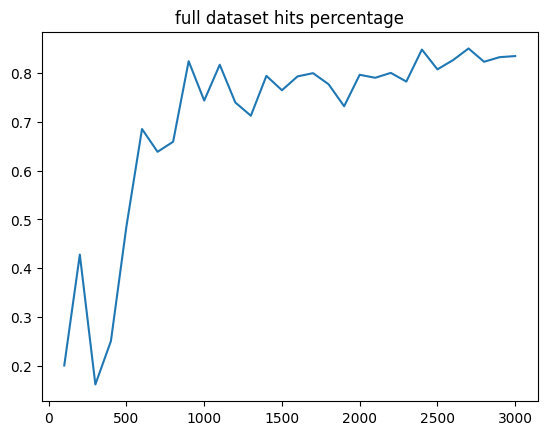

In [11]:
plt.title('full dataset hits percentage')
plt.plot(iterations, np.array(train_total)/len(digits.data))

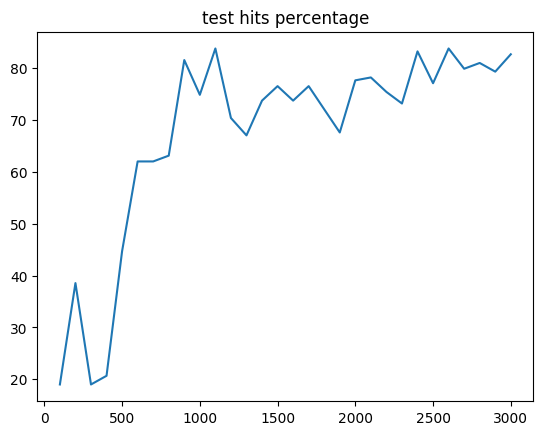

In [12]:
plt.title('test hits percentage')
plt.plot(iterations, test_percent)